In [1]:
# OBS: TREINAMENTO COM 16kHz, 16b e 1s

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
import sys
# We add this path so we can import the speech processing modules.
sys.path.append("tensorflow/tensorflow/examples/speech_commands/")
import input_data
import models

In [4]:
# Uma lista delimitada por vírgulas das palavras que você deseja treinar.
# As opções são: sim, não, cima, baixo, esquerda, direita, ligar, desligar, parar, ir
# Todas as outras palavras serão usadas para treinar um rótulo "desconhecido" e silenciar
# dados de áudio sem palavras faladas serão usados ​​para treinar um rótulo de "silêncio".
WANTED_WORDS = "bom,mediano,ruim"

# O número de etapas e taxas de aprendizagem podem ser especificados separados por vírgula
# listas para definir a taxa em cada etapa. Por exemplo,
#TRAINING_STEPS=12000,3000 e LEARNING_RATE=0,001,0,0001
# executará 12.000 loops de treinamento no total, com uma taxa de 0,001 para o primeiro
# 8.000 e 0,0001 para os 3.000 finais.
TRAINING_STEPS = "4000,1000" #MODIFIED TO MAKE FASTER - WAS 12000,3000
LEARNING_RATE = "0.001,0.0001"

# Calcule o número total de etapas usadas para identificar o ponto de verificação
# nome do arquivo.
TOTAL_STEPS = str(sum(map(lambda string: int(string), TRAINING_STEPS.split(","))))

# Print the configuration to confirm it
print("Training these words: %s" % WANTED_WORDS)
print("Training steps in each stage: %s" % TRAINING_STEPS)
print("Learning rate in each stage: %s" % LEARNING_RATE)
print("Total number of training steps: %s" % TOTAL_STEPS)

Training these words: bom,mediano,ruim
Training steps in each stage: 4000,1000
Learning rate in each stage: 0.001,0.0001
Total number of training steps: 5000


In [5]:
# Calculate the percentage of 'silence' and 'unknown' training samples required
# to ensure that we have equal number of samples for each label.
number_of_labels = WANTED_WORDS.count(',') + 1
number_of_total_labels = number_of_labels + 2 # for 'silence' and 'unknown' label
equal_percentage_of_training_samples = int(100.0/(number_of_total_labels))
SILENT_PERCENTAGE = equal_percentage_of_training_samples
UNKNOWN_PERCENTAGE = equal_percentage_of_training_samples

# Constants which are shared during training and inference
PREPROCESS = 'micro' # Modificado from 'micro' to 'average'
WINDOW_STRIDE = 20.0
MODEL_ARCHITECTURE = 'tiny_conv' # Other options include: single_fc, conv,
                      # low_latency_conv, low_latency_svdf, tiny_embedding_conv

# Constants used during training only
VERBOSITY = 'INFO' # MODIFIED FROM WARN TO INFO
EVAL_STEP_INTERVAL = '1000'
SAVE_STEP_INTERVAL = '1000'
# ADDED FOR INSPECCION
BACKGROUND_FREQUENCY = 0.8 #MODIFIED FROM 0.8 TO 0.4
BACKGROUND_VOLUME_RANGE = 0.1
TIME_SHIFT_MS = 100.0 #MODIFIED FROM 100 TO 0


# Constants for training directories and filepaths
DATASET_DIR =  'dataset-16kHz-16b-1s/'
LOGS_DIR = 'logs/'
TRAIN_DIR = 'train/' # for training checkpoints and other files.

# Constants for inference directories and filepaths
import os
MODELS_DIR = 'models'
if not os.path.exists(MODELS_DIR):
  os.mkdir(MODELS_DIR)
MODEL_TF = os.path.join(MODELS_DIR, 'model.pb')
MODEL_TFLITE = os.path.join(MODELS_DIR, 'model.tflite')
FLOAT_MODEL_TFLITE = os.path.join(MODELS_DIR, 'float_model.tflite')
MODEL_TFLITE_MICRO = os.path.join(MODELS_DIR, 'model.cc')
SAVED_MODEL = os.path.join(MODELS_DIR, 'saved_model')

QUANT_INPUT_MIN = 0.0
QUANT_INPUT_MAX = 26.0
QUANT_INPUT_RANGE = QUANT_INPUT_MAX - QUANT_INPUT_MIN

In [6]:
SAMPLE_RATE = 16000
CLIP_DURATION_MS = 1000
WINDOW_SIZE_MS = 30.0
FEATURE_BIN_COUNT = 40
#DATA_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
DATA_URL = ''
VALIDATION_PERCENTAGE = 10
TESTING_PERCENTAGE = 10

In [7]:
model_settings = models.prepare_model_settings(
    len(input_data.prepare_words_list(WANTED_WORDS.split(','))),
    SAMPLE_RATE, CLIP_DURATION_MS, WINDOW_SIZE_MS,
    WINDOW_STRIDE, FEATURE_BIN_COUNT, PREPROCESS)
audio_processor = input_data.AudioProcessor(
    DATA_URL, DATASET_DIR,
    SILENT_PERCENTAGE, UNKNOWN_PERCENTAGE,
    WANTED_WORDS.split(','), VALIDATION_PERCENTAGE,
    TESTING_PERCENTAGE, model_settings, LOGS_DIR)

In [8]:
# Load training data
np.random.seed(0) # set random seed for reproducible test results.
with tf.compat.v1.Session() as sess:
    train_data, train_labels = audio_processor.get_data(
        -1, 0, model_settings, BACKGROUND_FREQUENCY, BACKGROUND_VOLUME_RANGE,
        TIME_SHIFT_MS, 'training', sess)


In [9]:
print(train_data.shape)
print(type(train_data[1][1]))
print(train_data[1])
print(train_labels.shape)
print(type(train_labels[1]))
print(train_labels)

(3098, 1960)
<class 'numpy.float64'>
[20.35837555 20.82168579 19.81330681 ... 16.78816605 17.387743
 16.84267235]
(3098,)
<class 'numpy.float64'>
[2. 2. 4. ... 2. 2. 3.]


In [10]:
min_val = np.min(train_data)
max_val = np.max(train_data)
mean_val = np.mean(train_data)
print(min_val)
print(max_val)
print(mean_val)

0.0
25.999855041503906
15.936754937483919


In [11]:
# Calcular o valor mínimo e máximo do conjunto de dados
#min_val = np.min(train_data)
#max_val = np.max(train_data)
min_val = 0.0
max_val = 26

# Aplicar normalização para todo o conjunto de dados
train_data_norm = ((train_data - min_val) / (max_val - min_val)) * 255 - 128
# Arredondar e converter para inteiros de 8 bits
train_data_norm = train_data_norm.astype(np.int8)

# Adequar labels para o tipo int8
train_labels_norm = train_labels.astype(np.int8)

# Exemplo de uso
print("Valores normalizados:", train_data_norm[1])


Valores normalizados: [71 76 66 ... 36 42 37]


In [ ]:
# Mapear valores para o range -128 a 127
np.set_printoptions(threshold=np.inf)
print(train_data[1])


# Mapear o intervalo [0, 670] para [-128, 127]

train_data_norm = ((((train_data * 256) + (666 / 2)) / 666) - 128)

# Arredondar e converter para inteiros de 8 bits
train_data_norm = np.round(train_data_norm).astype(np.int8)

# Adequar labels para o tipo int8
train_labels_norm = train_labels.astype(np.int8)
print(type(train_labels_norm[1]))



In [ ]:
# Mapear valores para o range -128 a 127
np.set_printoptions(threshold=np.inf)
print(train_data[1])


# Mapear o intervalo [-1.0, 1.0] para [-128, 127]
#features_mapped = ((features + 1.0) * (127 + 128) / 2) - 128

train_data_norm = ((train_data * 255) / 26) - 128

# Arredondar e converter para inteiros de 8 bits
train_data_norm = np.round(train_data_norm).astype(np.int8)

# Adequar labels para o tipo int8
train_labels_norm = train_labels.astype(np.int8)
print(type(train_labels_norm[1]))



In [ ]:
# Exibir o resultado
print(train_data_norm.shape)
print(type(train_data_norm[1][1]))
print(train_data_norm[1])

In [ ]:
#Salvar dados em .csv
np.savetxt("data2.csv", train_data, delimiter=',', fmt='%f')
np.savetxt("labels2.csv", train_labels, delimiter=',', fmt='%d')

In [14]:
#Salvar dados em .csv
np.savetxt("data50.csv", train_data_norm, delimiter=',', fmt='%d')
np.savetxt("labels50.csv", train_labels_norm, delimiter=',', fmt='%d')

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [15]:
# Carregar dados
X = train_data_norm
y = train_labels_norm
n_trees = 13
depth = 6

#Dividir dados em treinamento e testes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

#Criar instância do classificador
clf = RandomForestClassifier(n_estimators=n_trees, max_depth=depth, random_state=seed)
#clf = RandomForestClassifier(n_estimators=n_trees, random_state=seed)


#Treinar modelo
clf.fit(X_train, y_train)

#Fazer previsões com o conjunto de testes
y_pred = clf.predict(X_test)

#Analisar Desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)

print(f"Acurácia do modelo: {accuracy}")

Acurácia do modelo: 0.9258064516129032


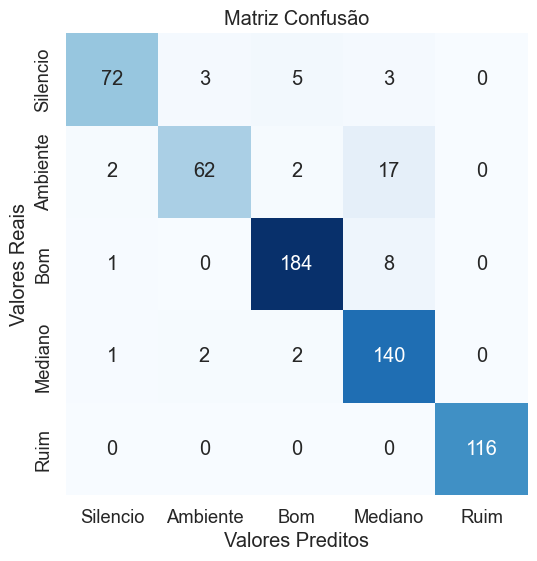

In [16]:
#Montar Matriz Confusão
cm = confusion_matrix(y_test, y_pred)
class_names = ["Silencio", "Ambiente", "Bom", "Mediano", "Ruim"]
#Configurar mapa de calor usando o seaborn
plt.figure(figsize=(8,6))
sns.set(font_scale=1.2)
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False,
            square=True,
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Valores Preditos")
plt.ylabel("Valores Reais")
plt.title("Matriz Confusão")

plt.show()

In [17]:
#Avaliar o desempenho com várias métricas
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.87      0.91        83
           1       0.93      0.75      0.83        83
           2       0.95      0.95      0.95       193
           3       0.83      0.97      0.89       145
           4       1.00      1.00      1.00       116

    accuracy                           0.93       620
   macro avg       0.93      0.91      0.92       620
weighted avg       0.93      0.93      0.92       620



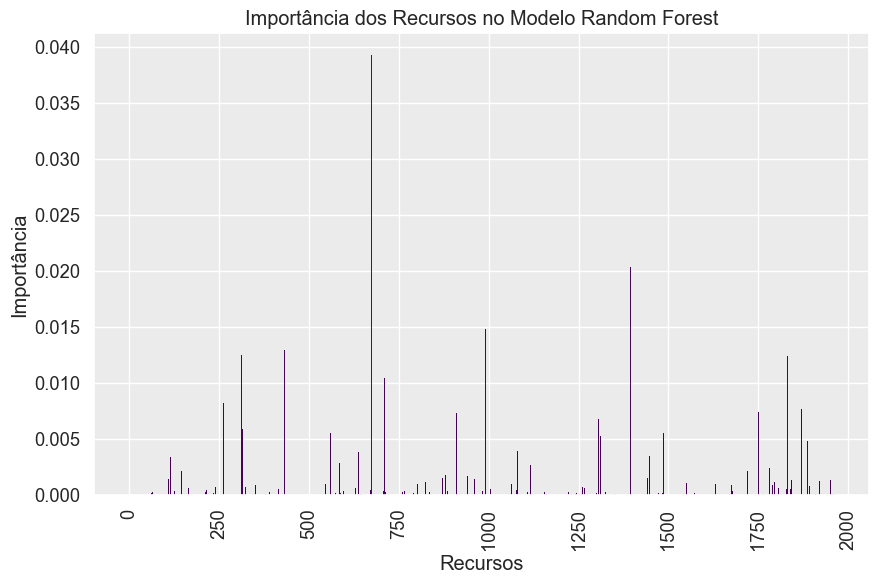

In [18]:
# Obtenha a importância dos recursos do modelo
feature_importances = clf.feature_importances_
#Escolha um mapa de cores
cmap = plt.colormaps.get_cmap('viridis')

# Crie um gráfico de importância de recursos
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, linewidth=0, color=cmap(feature_importances))
#plt.bar(range(len(feature_importances)), feature_importances, color='blue', linewidth=0)
plt.gca().set_facecolor('#EBEBEB')
plt.xlabel('Recursos')
plt.ylabel('Importância')
plt.title('Importância dos Recursos no Modelo Random Forest')
plt.xticks(rotation=90)
plt.show()

In [19]:
import dtreeviz

In [20]:
# Escolha uma das árvores do modelo (por exemplo, a primeira árvore)
n_tree = 0

tree = clf.estimators_[n_tree]
#feature_names = (str(number) for number in range(2099))
# Crie uma visualização da árvore com a biblioteca dtreeviz
viz = dtreeviz.model(tree, X, y,
               target_name='classe',
               #feature_names=data.feature_names,
               #class_names=list(data.target_names))
               feature_names=pd.DataFrame(X_train).columns,
               class_names=class_names)

# Exiba a visualização da árvore
v = viz.view()
v.show()

#Salve a imagem da árvore
v.save("./tree-"+str(n_tree)+".svg")


38.0 <= 166 
42.5 <= 312 
455 < 39.5
37.5 <= 824 
995 < 59.5
1949 < 47.5



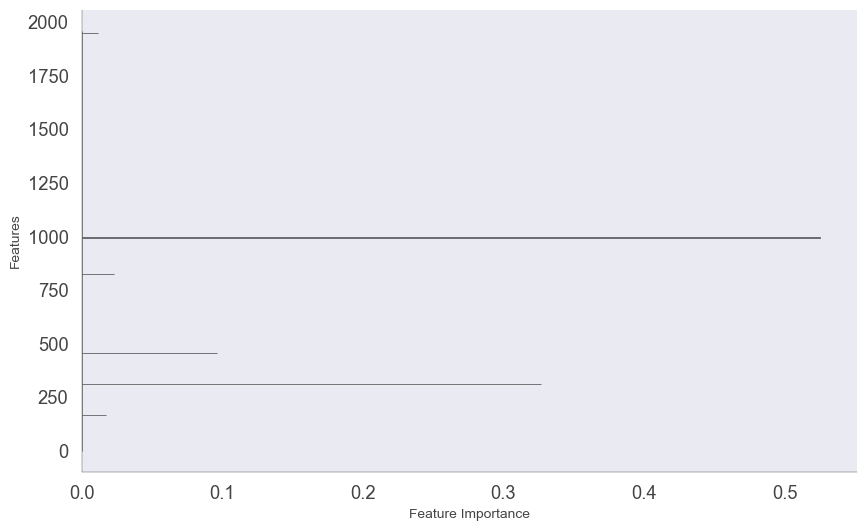

In [21]:
# Mostrar o caminho de decisão de uma amostra
x = X[10,:]
#print(x)
#print(y[10])

print(viz.explain_prediction_path(x))

# Mostrar a importância de cada feature de uma amostra
viz.instance_feature_importance(x, figsize=(10,6))

In [22]:
# Exportar modelo para código C

from micromlgen import port


if __name__ == '__main__': 
        classmap = {
        0: 'Silencio',
        1: 'Ambiente',
        2: 'Bom',
        3: 'Mediano',
        4: 'Ruim'
    }
        c_code = port(clf, classmap=classmap)
        with open('RandomForestClassifier-Final-NORMAL-13tree-6depth-norm.h', 'w') as file:
            file.write(c_code)

In [ ]:
indices = (y==0)
classe_0 = (X[indices])
indices = (y==1)
classe_1 = (X[indices])
indices = (y==2)
classe_2 = (X[indices])
indices = (y==3)
classe_3 = (X[indices])
indices = (y==4)
classe_4 = (X[indices])

In [ ]:
rows = 2
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

ax = axes[0][0]
ax.boxplot(np.mean(classe_0, axis=0), vert=False)
#    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
ax.set_title("Classe Silêncio")

ax = axes[0][0]
ax.boxplot(np.mean(classe_1, axis=0), vert=False)
#    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
ax.set_title("Classe Ambiente")

ax = axes[0][1]
ax.boxplot(np.mean(classe_2, axis=0), vert=False)
#    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
ax.set_title("Classe Bom")

ax = axes[0][2]
ax.boxplot(np.mean(classe_3, axis=0), vert=False)
#    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
ax.set_title("Classe Mediano")

ax = axes[1][0]
ax.boxplot(np.mean(classe_4, axis=0), vert=False)
#    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
ax.set_title("Classe Ruim")

plt.show()